/Users/hamaguchikazuki/.pyenv/versions/3.6.5/envs/ppgVC/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


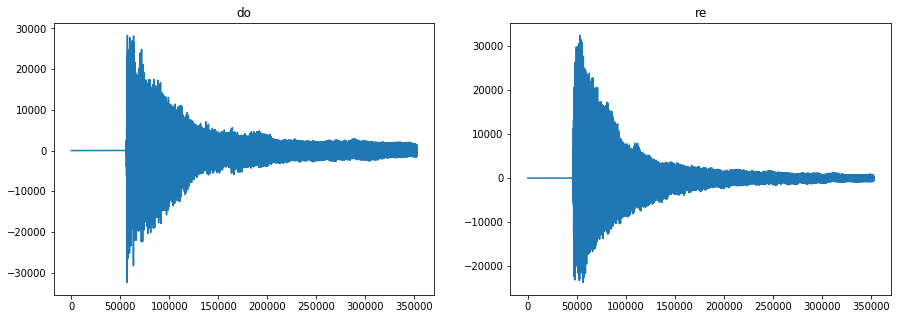

In [58]:
import wave
import numpy
import pylab

def data_form_wav(filename):
    f = wave.open(filename, 'r')
    buf = f.readframes(f.getnframes())
    return numpy.frombuffer(buf, dtype='int16')

if __name__ == '__main__':
    fig, (l, r) = pylab.subplots(ncols=2,  figsize=(15,5))
    l.plot(data_form_wav('do/do3.wav'))
    l.set_title('do')
#     l.set_xlim(15000, 48000)
    r.plot(data_form_wav('re/re3.wav'))
    r.set_title('re')
#     r.set_xlim(15000, 48000)
    fig.show()
#     fig.savefig('do-re.png')
    
    

/Users/hamaguchikazuki/.pyenv/versions/3.6.5/envs/ppgVC/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


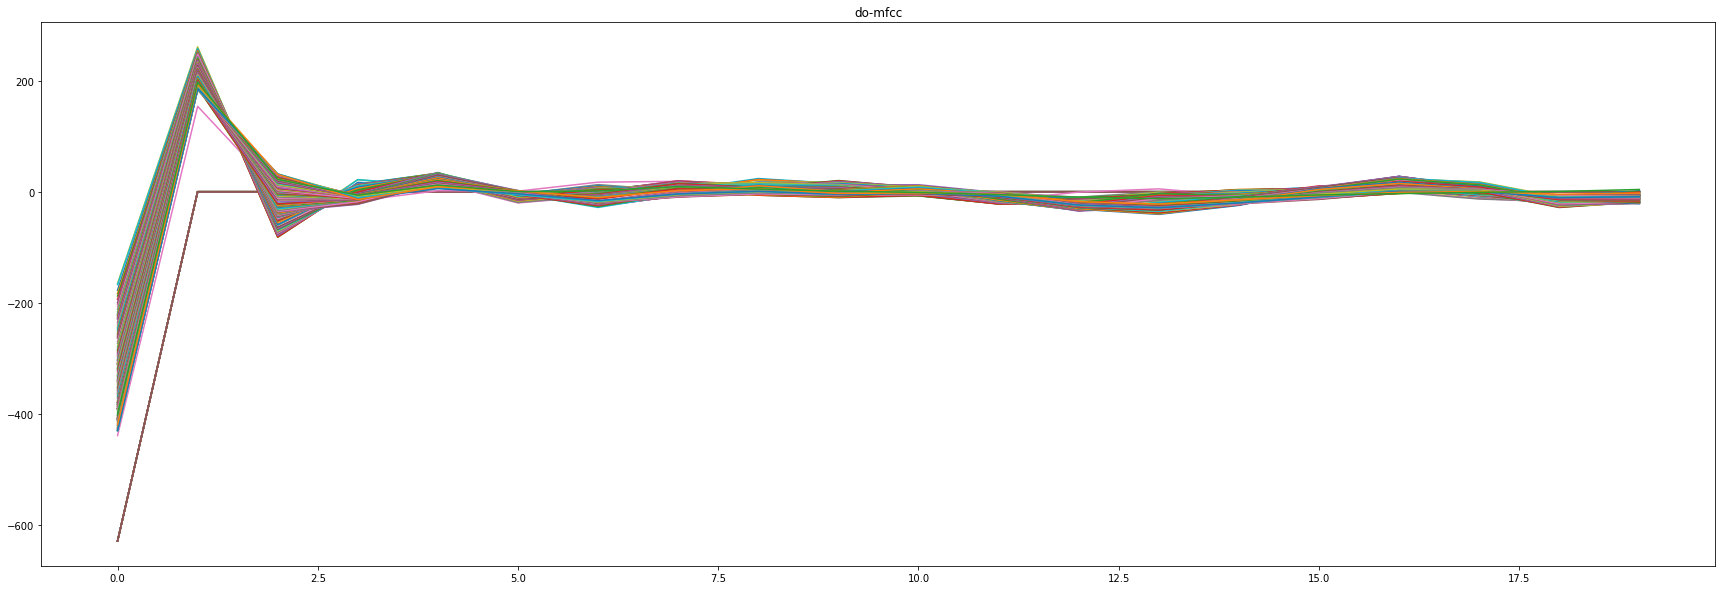

In [59]:
import librosa
import numpy

def get_mfcc(fname):
    y, sr = librosa.load(fname)
    return librosa.feature.mfcc(y, sr)

if __name__ == '__main__':
    do = get_mfcc('do/do3.wav')
    fig, l = pylab.subplots(ncols=1, figsize=(30,10))
    l.plot(do)
    l.set_title('do-mfcc')
#     fig.savefig('do-mfcc.png')
    fig.show()


In [55]:
import scipy.io.wavfile as wav
import librosa
from sklearn.svm import SVC
import numpy

piano_notes = ['do', 're']
piano_sounds = list(range(16))

piano_note_training = []
piano_sound_training = []

for piano_note in piano_notes:
    print('Reading data of {}...'.format(piano_note))
    for piano_sound in piano_sounds:
        print('{}/{}{}.wav'.format(piano_note, piano_note, piano_sound))
        mfcc = get_mfcc('{}/{}{}.wav'.format(piano_note, piano_note, piano_sound))
        piano_sound_training.append(mfcc.T)
        label = numpy.full((mfcc.shape[1], ), 
                           piano_notes.index(piano_note), dtype=numpy.int)
        piano_note_training.append(label)

piano_sound_training = numpy.concatenate(piano_sound_training)
piano_note_training = numpy.concatenate(piano_note_training)
print('done')

Reading data of do...
do/do0.wav
do/do1.wav
do/do2.wav
do/do3.wav
do/do4.wav
do/do5.wav
do/do6.wav
do/do7.wav
do/do8.wav
do/do9.wav
do/do10.wav
do/do11.wav
do/do12.wav
do/do13.wav
do/do14.wav
do/do15.wav
Reading data of re...
re/re0.wav
re/re1.wav
re/re2.wav
re/re3.wav
re/re4.wav
re/re5.wav
re/re6.wav
re/re7.wav
re/re8.wav
re/re9.wav
re/re10.wav
re/re11.wav
re/re12.wav
re/re13.wav
re/re14.wav
re/re15.wav
done


/Users/hamaguchikazuki/.pyenv/versions/3.6.5/envs/ppgVC/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


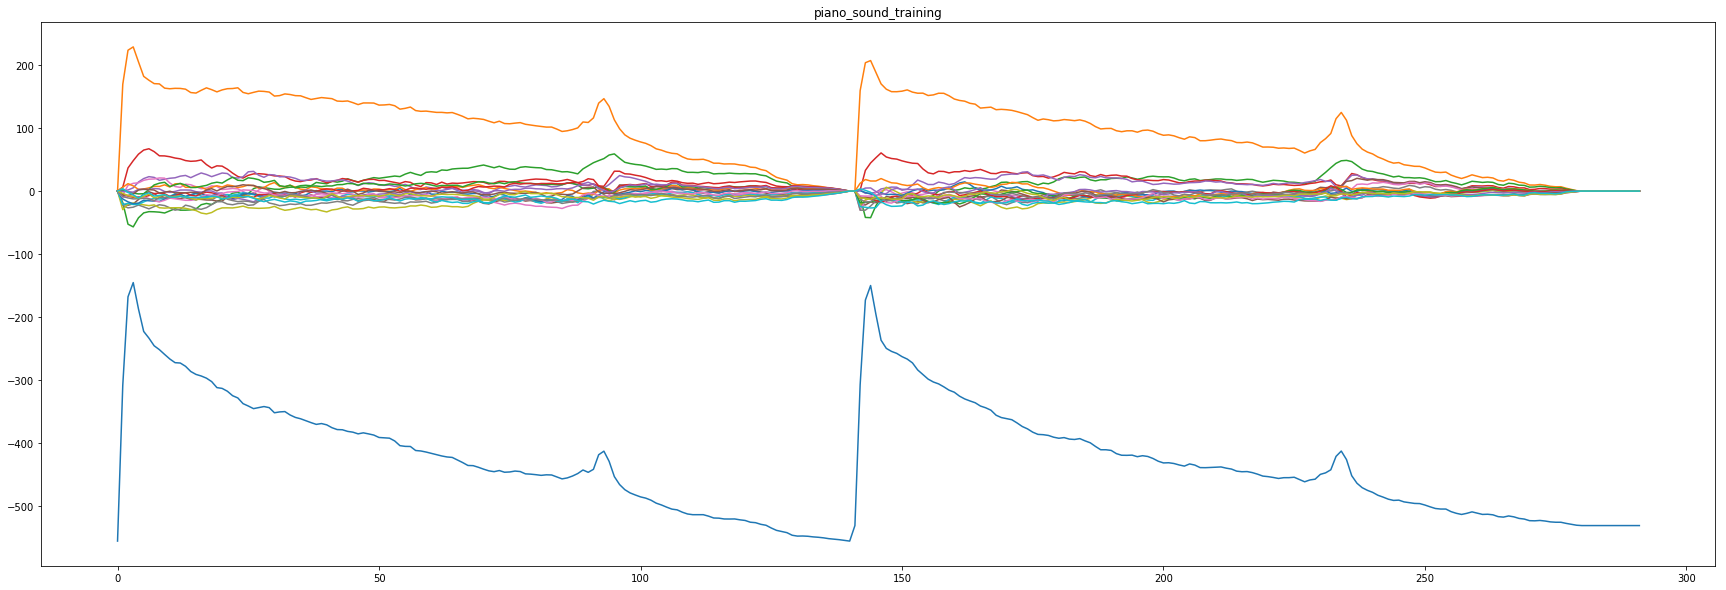

In [20]:
fig, l = pylab.subplots(ncols=1, figsize=(30,10))
l.plot(piano_sound_training)
l.set_title('piano_sound_training')
fig.savefig('training.png')
fig.show()

In [69]:
# そのまま判定
svc = SVC()
svc.fit(piano_sound_training, piano_note_training)
print('Learning Done')

piano_sounds_test = list(range(16,18))
for piano_note in piano_notes:
    for piano_sound in piano_sounds_test:
        print('piano test sound {}{}'.format(piano_note, piano_sound))
        mfcc = get_mfcc('{}/{}{}.wav'.format(piano_note, piano_note,piano_sound))
        prediction = svc.predict(mfcc.T)
        counts = numpy.bincount(prediction) 
        result = piano_notes[numpy.argmax(counts)] # 音程の判定
        original_title = '{}'.format(piano_note)
        print('original note is {}. Prediction of note is {}'.format(original_title, result))

Learning Done
piano test sound do16
original note is do. Prediction of note is do
piano test sound do17
original note is do. Prediction of note is do
piano test sound re16
original note is re. Prediction of note is do
piano test sound re17
original note is re. Prediction of note is do


In [74]:
# C, gammaの値を変更 * 1e-3より正しく分けられている
svc = SVC(gamma = 1e-3)
svc.fit(piano_sound_training, piano_note_training)
print('Learning Done')

piano_sounds_test = list(range(16,18))
for piano_note in piano_notes:
    for piano_sound in piano_sounds_test:
        print('piano test sound {}{}'.format(piano_note, piano_sound))
        mfcc = get_mfcc('{}/{}{}.wav'.format(piano_note, piano_note,piano_sound))
        prediction = svc.predict(mfcc.T)
        counts = numpy.bincount(prediction) 
        result = piano_notes[numpy.argmax(counts)] # 音程の判定
        original_title = '{}'.format(piano_note)
        print('original note is {}. Prediction of note is {}'.format(original_title, result))

Learning Done
piano test sound do16
original note is do. Prediction of note is do
piano test sound do17
original note is do. Prediction of note is do
piano test sound re16
original note is re. Prediction of note is re
piano test sound re17
original note is re. Prediction of note is re
